In [320]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.optimize as optimize
import scipy.stats as stats
plt.rcParams['savefig.dpi'] = 600

## 1) Preparing the growth data

All tested 5-FC concetrations for three BY4742 strains are included within the same 96 well plate

In [323]:
plate_config = pd.read_csv("Data_for_SFigs/config_40_23_09_15_SA.csv")
plate_data = pd.read_csv("Data_for_SFigs/Tecan40_23_09_17_SA.csv", encoding='unicode_escape')

In [324]:
# Reformatting the growth data
temp_5FC = plate_data.iloc[0, 1:].copy()  # Separating the temperature timeseries, in case we want to use it later
OD_5FC = plate_data.iloc[1:, :].copy()
OD_5FC = OD_5FC.dropna(subset=['Unnamed: 0']).reset_index(drop=True).copy()
OD_5FC = OD_5FC.rename(columns={'Unnamed: 0': 'Well'})

# Reformatting the well column
OD_5FC['Well'] = OD_5FC['Well'].apply(lambda x: x[0]+'0'+x[1] if len(x)==2 else x)
plate_config = plate_config.rename(columns={'well': 'Well'})
plate_config['Well'] = plate_config['Well'].apply(lambda x: x[0]+'0'+x[1] if len(x)==2 else x)

In [325]:
# Preparing a df of OD values adjusted to 1 ml
OD_5FC = OD_5FC[OD_5FC['Well'] != 'A01'].copy().reset_index(drop=True)  # One well is missing from the data ?!?
OD_5FC = pd.melt(OD_5FC, id_vars=['Well'], value_vars=OD_5FC.columns[1:], var_name='time', value_name= 'OD')

data_5FC = pd.merge(plate_config, OD_5FC, on=['Well'], how='right')
data_5FC['time'] = data_5FC['time'].apply(lambda x: int(x[:-1]))
data_5FC = data_5FC.infer_objects()
data_5FC = data_5FC.astype({'OD': 'float64'})
data_5FC['Time (hours)'] = data_5FC['time'] / 3600
med_T0 = np.median(data_5FC[(data_5FC['Time (hours)'] < 0.2) & (data_5FC['strain'] == 'Blank')]['OD'])
data_5FC['Adj_OD'] = (data_5FC['OD'] - med_T0) * 5  # Because there are no empty wells, the median at T0 is substracted

### Computing the robust linear and exponential growth rates for each well

In [327]:
def get_derivative_growth_rate(data, well, well_col, time_int, OD_col, OD_scale):
    
    well_subset = data[data[well_col] == well].copy().reset_index(drop=True)
    well_subset['OD_norm'] = well_subset[OD_col]*OD_scale
    well_subset['OD_diff'] = well_subset['OD_norm'].diff()

    top10_indexes = well_subset['OD_diff'].nlargest(10).index

    top10_subset = well_subset.iloc[np.r_[top10_indexes], :].copy()
    top10_subset['OD_deriv'] = top10_subset['OD_diff'] / time_int

    deriv_growth = np.median(top10_subset['OD_deriv'])
    sd_deriv = np.std(top10_subset['OD_deriv'])

    return deriv_growth, sd_deriv

In [328]:
def get_max_log_deriv(data, well, well_col, time_int, OD_col, OD_scale):
    
    well_subset = data[data[well_col] == well].copy().reset_index(drop=True)
    well_subset['OD_norm'] = well_subset[OD_col]*OD_scale
    well_subset['Log_OD'] = np.log(well_subset['OD_norm'])
    
    top5_log = well_subset['Log_OD'].diff().nlargest(10) / time_int

    slope_log= np.median(top5_log)
    sd_log = np.std(top5_log)

    return slope_log, sd_log

In [329]:
rates_BY4742 = data_5FC[['Well', 'strain', 'Replicate', 'condition']].copy().drop_duplicates()
rates_BY4742 = rates_BY4742[rates_BY4742['strain'] != 'Blank'].copy().reset_index(drop=True)

In [330]:
rates_BY4742['Max_lin_adj'] = rates_BY4742['Well'].apply(lambda x: get_derivative_growth_rate(data_5FC, x, 'Well', 0.25, 'Adj_OD', 1)[0])
rates_BY4742['Max_lin_rate'] = rates_BY4742['Well'].apply(lambda x: get_derivative_growth_rate(data_5FC, x, 'Well', 0.25, 'OD', 5)[0])
rates_BY4742['Max_log_adj'] = rates_BY4742['Well'].apply(lambda x: get_max_log_deriv(data_5FC, x, 'Well', 0.25, 'Adj_OD', 1)[0])
rates_BY4742['Max_log_rate'] = rates_BY4742['Well'].apply(lambda x: get_max_log_deriv(data_5FC, x, 'Well', 0.25, 'OD', 5)[0])

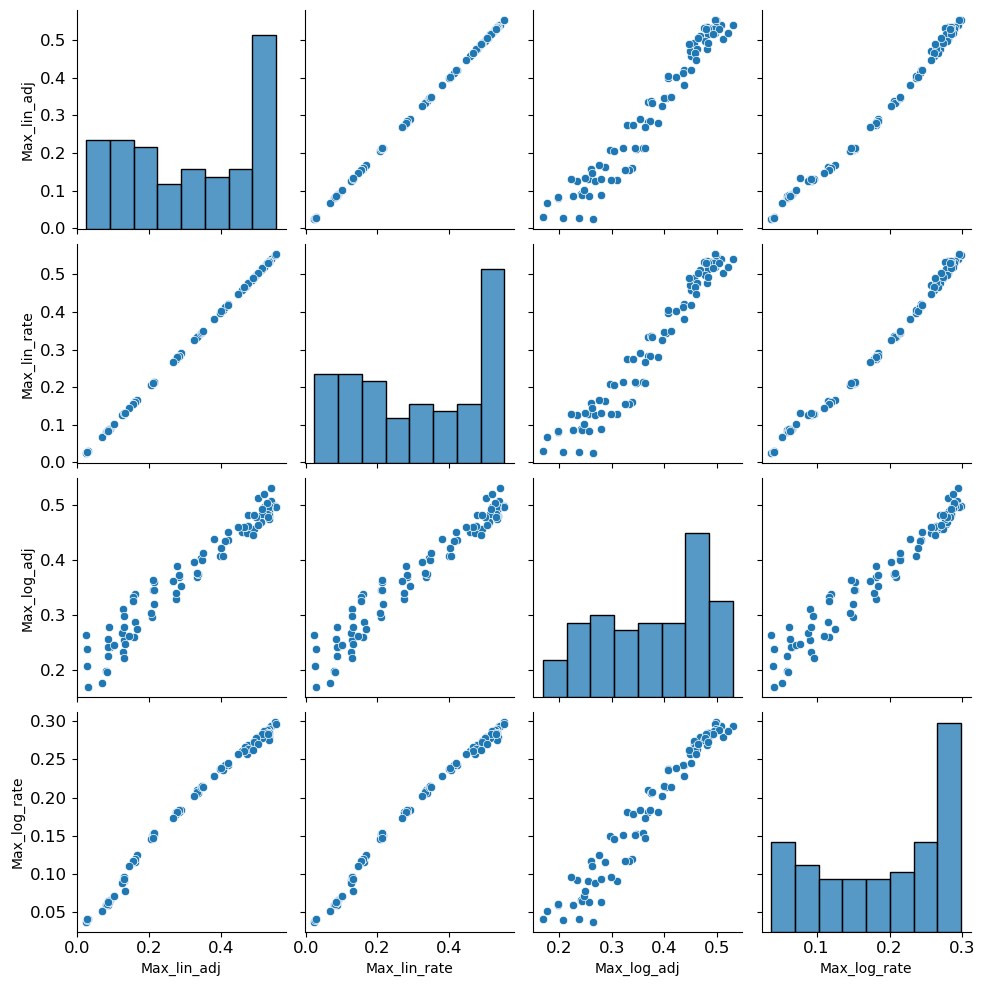

In [331]:
sns.pairplot(rates_BY4742[['Max_lin_adj', 'Max_lin_rate', 'Max_log_adj', 'Max_log_rate']])

It remains true that adjusting OD (substracting the blank) inflates the max exponential rate. But does it impacts the corresponding selection coefficients?

Computing the corresponding selection coefficients (not used here, but as a test)

In [334]:
# Obtain median WT growth (the same WT data is in each df, so it should be the same)
rates_none = rates_BY4742[rates_BY4742['condition'] == 'No 5FC'].copy().reset_index(drop=True)
wt_lin_adj = np.median(rates_none[rates_none['strain'] == 'AKD1123']['Max_lin_adj'])
wt_lin = np.median(rates_none[rates_none['strain'] == 'AKD1123']['Max_lin_rate'])
wt_log_adj = np.median(rates_none[rates_none['strain'] == 'AKD1123']['Max_log_adj'])
wt_log = np.median(rates_none[rates_none['strain'] == 'AKD1123']['Max_log_rate'])

# Computing selection coefficients
rates_BY4742['s_log'] = ((rates_BY4742['Max_log_rate'] - wt_log) / wt_log) * np.log(2)
rates_BY4742['s_log_adj'] = ((rates_BY4742['Max_log_adj'] - wt_log_adj) / wt_log_adj) * np.log(2)
rates_BY4742['s_lin'] = ((rates_BY4742['Max_lin_rate'] - wt_lin) / wt_lin) * np.log(2)
rates_BY4742['s_lin_adj'] = ((rates_BY4742['Max_lin_adj'] - wt_lin_adj) / wt_lin_adj) * np.log(2)

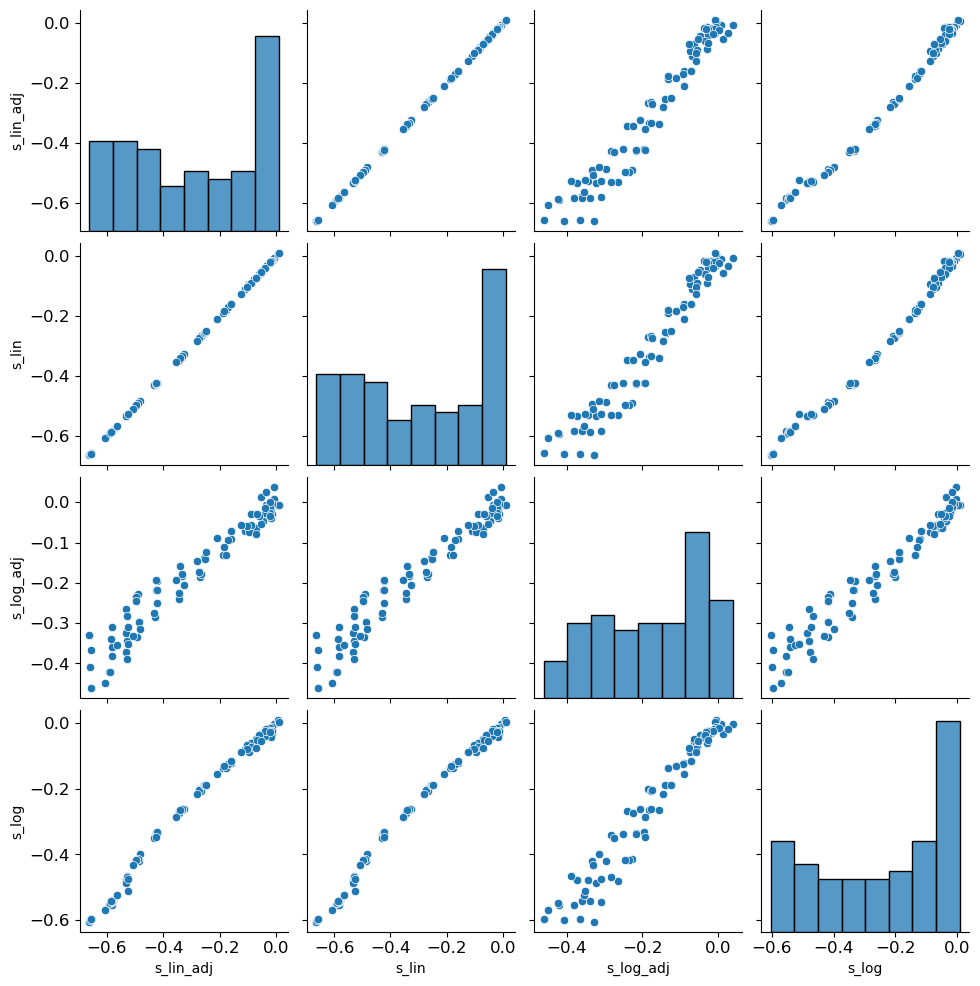

In [335]:
sns.pairplot(rates_BY4742[['s_lin_adj', 's_lin', 's_log_adj', 's_log']])

All selection coefficients agree, except for the ones computed from exponential rates obtained from blank-adjusted OD. This surprisingly introduces a lot of noise!

This validates other analyses where selection coefficients have been computed from growth data!

## 2) Computing relative inhibition for each 5-FC concentration and fitting dose-response curves

First, relative inhibition:

In [340]:
conc_dict = {'1/64 x IC50': 9.14/64, '8 x IC50': 9.14*8, '16 x IC50': 9.14*16, '32 x IC50': 9.14*32, '1/32 x IC50': 9.14/32,
             '1/16 x IC50': 9.14/16, '1/8 x IC50': 9.14/8, '1/4 x IC50': 9.14/4, '1/2 x IC50': 9.14/2, '1 x IC50': 9.14,
             '2 x IC50': 9.14*2, '4 x IC50': 9.14*4, 'No 5FC': 0}

In [341]:
rates_BY4742['5FC concentration'] = rates_BY4742['condition'].apply(lambda x: conc_dict[x])
rates_BY4742['Log2 5FC concentration'] = np.log2(rates_BY4742['5FC concentration'])

F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [342]:
def get_rel_inhib(data_df, strain_col, rate_col, max_condition, out_col):
    data_out = pd.DataFrame(columns=data_df.columns)
    for strain in data_df[strain_col].unique():
        subset_current = data_df[data_df[strain_col] == strain].copy()
        max_growth = subset_current[subset_current['condition'] == max_condition][rate_col].median()
        subset_current[out_col] = 1 - (subset_current[rate_col] / max_growth)

        data_out = pd.concat([data_out, subset_current]).reset_index(drop=True)

    return data_out 

In [343]:
inhib_log = get_rel_inhib(rates_BY4742, 'strain', 'Max_log_rate', 'No 5FC', 'Rel_inhib_log')
inhib_lin = get_rel_inhib(rates_BY4742, 'strain', 'Max_lin_rate', 'No 5FC', 'Rel_inhib_lin')

C:\Users\tiger\AppData\Local\Temp\ipykernel_372\1480621615.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_out = pd.concat([data_out, subset_current]).reset_index(drop=True)
C:\Users\tiger\AppData\Local\Temp\ipykernel_372\1480621615.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_out = pd.concat([data_out, subset_current]).reset_index(drop=True)


In [344]:
# Removing wells with no 5-FC (problematic for log2 concentration)
inhib_log = inhib_log[inhib_log['condition'] != 'No 5-FC'].copy().reset_index(drop=True)
inhib_lin = inhib_lin[inhib_lin['condition'] != 'No 5-FC'].copy().reset_index(drop=True)

In [345]:
inhib_all = pd.merge(inhib_log, inhib_lin)

Then, fitting of dose-response curves:

In [347]:
def hill_equation(x, E, n):
    
    return 1/(1+((E/x)**n))

In [348]:
def hill_fit(data, id_col, id, conc_col, rel_col):
    """Function which returns a dataframe containing the subset of experimental data used in the current fit, as well as the two parameters"""
    df_to_fit = data[data[id_col] == id].copy().reset_index(drop=True)

    params, pcov = optimize.curve_fit(hill_equation, df_to_fit[conc_col], df_to_fit[rel_col])

    return df_to_fit, params

In [349]:
def gen_hill_data(conc_bounds, params_fit, params_ref):
    """Function which generates two dataframes from which the newly fitted curve and an additional reference curve can be plotted"""

    conc_series = np.logspace(np.log2(conc_bounds[0]), np.log2(conc_bounds[1]), num=75, base=2)

    df_model = pd.DataFrame(columns=['Concentration', 'Log2 concentration (uM)', 'Growth inhibition'])

    df_fit = df_model.copy()
    df_fit['Concentration'] = conc_series
    df_fit['Log2 concentration (uM)'] = np.log2(df_fit['Concentration']) 
    df_fit['Growth inhibition'] = hill_equation(df_fit['Concentration'], params_fit[0] , params_fit[1])

    df_ref = df_model.copy()
    df_ref['Concentration'] = conc_series
    df_ref['Log2 concentration (uM)'] = np.log2(df_ref['Concentration']) 
    df_ref['Growth inhibition'] = hill_equation(df_ref['Concentration'], params_ref[0] , params_ref[1])

    return df_fit, df_ref

In [350]:
def plot_dose_response(data, id_col, conc_col, inhib_lin_col, inhib_log_col, x_dim, y_dim, order=None):
    """Function to plot dose-response curves, annotated with IC50 and Hill exponent, for each strain assayed"""
    n_graphs = 2*data['strain'].unique().shape[0]

    plt.rcParams["ytick.labelsize"] = 12
    plt.rcParams["xtick.labelsize"] = 12

    # Setting the dimensions of the figure
    if n_graphs >= 3:
        n_cols = 3
    else:
        n_cols = n_graphs

    if n_graphs <= 3:
        n_rows = 1

    else:
        n_rows = math.ceil((n_graphs/3))

    # Creating the figure
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(x_dim, y_dim), sharey='row')

    axs_list = fig.axes

    current_fig = 0

    if not order:
        order = data[id_col].unique()

    # First, for lin-based inhibition
    for strain in order:
        # Fitting the equation
        df_exp, params_fit = hill_fit(data, id_col, strain, conc_col, inhib_lin_col)

        # Generating the two curves (new fit and reference)
        df_fit, df_ref = gen_hill_data((0.1, 1000), params_fit, (9.1395844 , 0.80356349))

        # Plotting the data
        axs_list[current_fig].scatter(np.log2(df_exp[conc_col]), df_exp[inhib_lin_col], c='tab:blue')
        axs_list[current_fig].plot(df_fit['Log2 concentration (uM)'], df_fit['Growth inhibition'])
        axs_list[current_fig].plot(df_ref['Log2 concentration (uM)'], df_ref['Growth inhibition'])
        axs_list[current_fig].set_title(f'{strain}', fontsize=18)
        axs_list[current_fig].annotate(f'IC50 = {round(params_fit[0], 4)}' r" $\mu$M" '\n'f'n = {round(params_fit[1], 4)}', (-3, 0.85))

        current_fig += 1

    # Then, same for log-based inhibition
    for strain in order:
        # Fitting the equation
        df_exp, params_fit = hill_fit(data, id_col, strain, conc_col, inhib_log_col)

        # Generating the two curves (new fit and reference)
        df_fit, df_ref = gen_hill_data((0.1, 1000), params_fit, (9.1395844 , 0.80356349))

        # Plotting the data
        axs_list[current_fig].scatter(np.log2(df_exp[conc_col]), df_exp[inhib_log_col], c='tab:blue')
        axs_list[current_fig].plot(df_fit['Log2 concentration (uM)'], df_fit['Growth inhibition'])
        axs_list[current_fig].plot(df_ref['Log2 concentration (uM)'], df_ref['Growth inhibition'])
        axs_list[current_fig].set_title(f'{strain}', fontsize=18)
        axs_list[current_fig].annotate(f'IC50 = {round(params_fit[0], 4)}' r" $\mu$M" '\n'f'n = {round(params_fit[1], 4)}', (-3, 0.85))

        current_fig += 1

        plt.tight_layout()

    return fig, axs

F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\

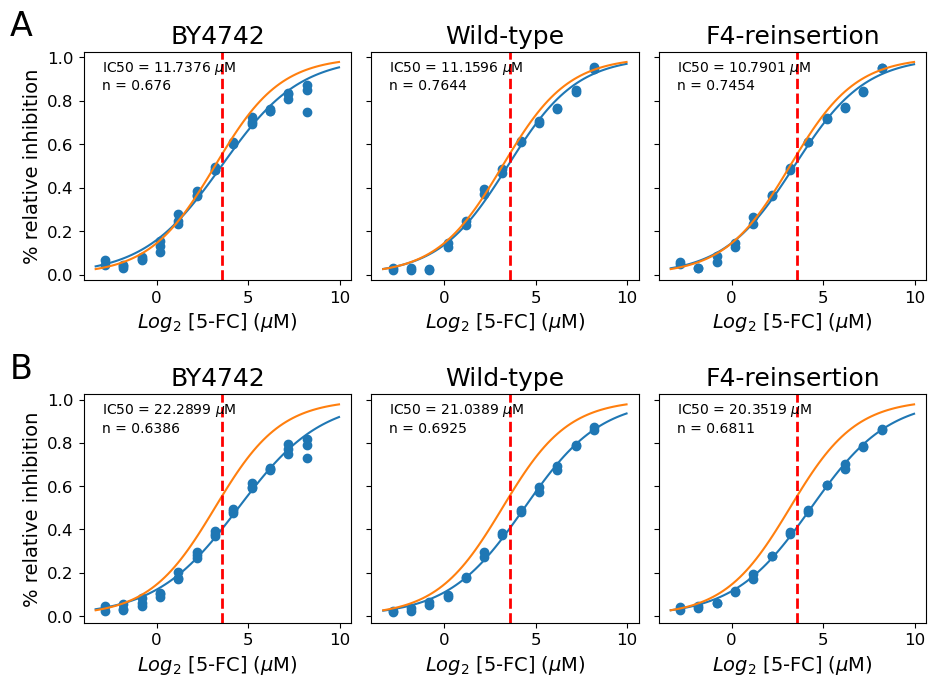

In [351]:
order_strains = ['BY4742', 'AKD1123', 'F4-AKD1123']
fig_test = plot_dose_response(inhib_all, 'strain', '5FC concentration', 'Rel_inhib_lin', 'Rel_inhib_log', 9.5, 7, order=order_strains)

fig_test[1][0,0].set_ylabel(r"% relative inhibition", fontsize=14)
fig_test[1][1,0].set_ylabel(r"% relative inhibition", fontsize=14)

for ax_row in [0, 1]:
    for ax_col in [0, 1, 2]:
        fig_test[1][ax_row, ax_col].axvline(x=math.log2(12), c='red', linestyle='--', linewidth=2)
        fig_test[1][ax_row, ax_col].set_xlabel(r"$Log_{2}$ [5-FC] ($\mu$M)", fontsize=14)

# Renaming the plots
fig_test[1][0,1].set_title('Wild-type', fontsize=18)
fig_test[1][1,1].set_title('Wild-type', fontsize=18)
fig_test[1][0,2].set_title('F4-reinsertion', fontsize=18)
fig_test[1][1,2].set_title('F4-reinsertion', fontsize=18)

# Annotating the two rows
fig_test[1][0,0].annotate('A', (-8, 1.10), fontsize=24, annotation_clip=False)
fig_test[1][1,0].annotate('B', (-8, 1.10), fontsize=24, annotation_clip=False)
plt.tight_layout()

# Saving the figure
FigS3 = plt.gcf()
FigS3.savefig('Supp_figs/S3Fig.tiff', bbox_inches='tight')